# Homework09

Exercises to practice dimensionality reduction with PCA

## Goals

- Add unsupervised pre-processing to our ML flow: encode -> normalize -> pre-process -> train -> evaluate
- Build an intuition for PCA and when/how to use it
- Understand the benefits of dimensionality reduction

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [164]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/Homework07/raw/main/Homework07_utils.pyc
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [165]:
import PIL.Image as PImage

from os import listdir, path

from data_utils import PCA, RandomForestClassifier

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same one we used in `Homework07`. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [166]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [167]:
# TODO: check and see what is inside the list here
train_files[:5]

['26-74.jpg', '26-04.jpg', '06-75.jpg', '28-64.jpg', '09-04.jpg']

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [168]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [169]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(label_data[:5])
print(train_files[:5])
len(pixel_data), len(label_data)

[21, 21, 4, 23, 7]
['26-74.jpg', '26-04.jpg', '06-75.jpg', '28-64.jpg', '09-04.jpg']


(250, 250)

Like in `Homework07`, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

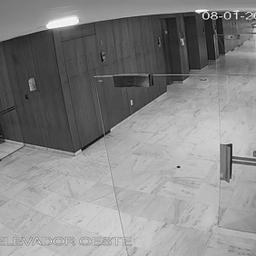

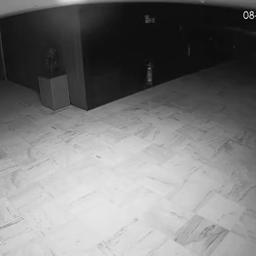

In [170]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did in Homewokr07 with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `Homework07`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [171]:
# TODO: run PCA, get DataFrame
pca = PCA(n_components=10)
cam_pca_df = pca.fit_transform(pixel_data)

# TODO: add "label" column
cam_pca_df["label"] = label_data

# TODO: print variance
print(pca.explained_variance())

# TODO: take a look at the first 5 rows
cam_pca_df.head()
len(pixel_data[:1][0])

0.7852542403246625


65536

### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

- I tried 5 and 10 components and made sure that the number of fields varies depending on the number.
- Since each pixel data originally has 65536(256*256) pixels, this means that we are able to compress 65536 to 5 or 10, depending on the number specified as n_components.

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

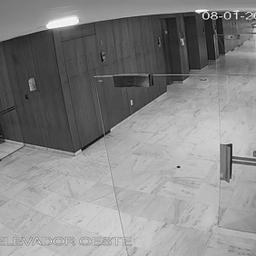

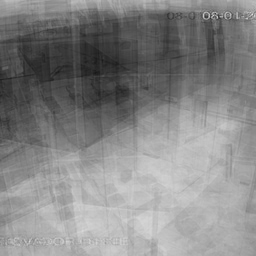

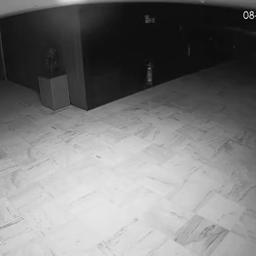

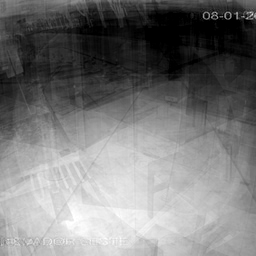

In [172]:
# TODO: reconstruct image at index 0
image_0_orig = pixel_data[0]
image_0_inversed = pca.inverse_transform(cam_pca_df.iloc[0])
display(make_image(image_0_orig, width=256))
display(make_image(image_0_inversed, width=256))

# TODO: reconstruct image at index 10
image_10_orig = pixel_data[10]
image_10_inversed = pca.inverse_transform(cam_pca_df.iloc[10])
display(make_image(image_10_orig, width=256))
display(make_image(image_10_inversed, width=256))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [173]:
# TODO: create a classifier
camera_classification_model = RandomForestClassifier()

# TODO: split input and output features
train_features = cam_pca_df.drop(columns="label")
train_labels = cam_pca_df["label"]

# TODO: fit the model
camera_classification_model.fit(train_features, train_labels)

# TODO: run predictions
train_predictions = camera_classification_model.predict(train_features)

### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [174]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

- An accuracy of 1.0 means the trained model perfectly identifies which camera is which based on the training data.
- While this typically indicates overfitting and is considered undesirable, I would say this is acceptable here.
- This is because the training data consists of CPA scores rather than raw camera footage and the raw footage has already been abstracted enough into higher-level features.

### Run on Test set

Now we'll open the image files inside the `./data/image/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [175]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/image/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print(len(test_files))

1573


We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [176]:
test_pixel_data = []

for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [177]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one
test_pca_df = pca.transform(test_pixel_data)

It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

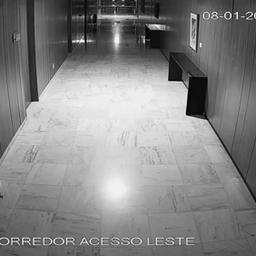

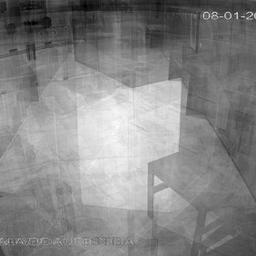

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,5948.657841,6330.132888,-3621.890595,-8428.274206,-593.701967,-1586.524673,526.319652,-1903.796493,1591.669947,-2044.387573
1,6211.182744,3488.556479,-13540.004535,-2898.963291,-3236.474263,2283.144398,-1857.311552,-1895.410842,82.619960,-2606.533826
2,2528.433141,609.504268,6733.134720,2773.863045,-2193.469090,1140.180708,-1651.647720,-1443.949766,3746.396355,203.065662
3,8575.003412,-6349.651012,3016.108873,-3711.876528,-2115.858656,386.776479,-3322.380687,5631.920476,1310.335016,-3510.865737
4,2945.599382,-6076.786610,-3970.465985,4992.683489,-447.851887,-706.183388,-3108.364092,-1069.514934,-2670.576986,2060.477508


In [178]:
# TODO: reconstruct one or two images
test_image_0_inversed = pca.inverse_transform(test_pca_df.iloc[0])
display(make_image(test_pixel_data[0], width=256))
display(make_image(test_image_0_inversed, width=256))

# TODO: take a look at the first 5 rows
test_pca_df.head()

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

- This is because this PCA is built on images of the training data, and the principal component is built using only what is shown in the images for training.
- It seems that the number of components should be adjusted, because the example image above shows the shadow of a table that is not shown in the original image, which is a sign of inaccurate training.



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [179]:
# TODO: run classifier. This is the same classifier already fitted on the train data above
test_predictions = camera_classification_model.predict(test_pca_df)

# TODO: get accuracy
CamUtils.classification_accuracy(test_files, test_predictions)

0.9230769230769231

### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to the classification model from <code>Homework07</code>? They can both be tuned to perform well, but how many features did we need last time in order to get an accuracy comparable to this?
</span>

- When I used 10 PCs, the prediction accuracy was 0.92.
- This result really surprised me, especially because the dataset only has 10 fields, and the reconstructed images didn’t look very promising to me.
- In Homework 07, the accuracy was only 0.65 when I used the first 10 pixels directly. This comparison shows how powerful PCA is in compressing data while preserving important features—even features that aren't obvious to the human eye.

- Observations with different numbers of PCs:
    - 1 PCA: Accuracy dropped to 0.42—it didn’t work well anymore.
    - 5 PCAs: Accuracy jumped to 0.90, which was surprising and showed that even a small number of components can retain essential image information.
    - 20 PCAs: Accuracy improved to 0.95, which was even higher than when I used the first 1000 pixels in Homework 07.
    - 100 and 1000 PCAs: Accuracy did not improve beyond 0.95, suggesting that we hit the performance ceiling given the quality and limit of the training data.